In [1]:
import sys
import torch

# 看看是不是用的 strawberry 环境里的 python
print("当前 Python 路径:", sys.executable)

# 看看 PyTorch 版本和显卡
print("PyTorch 版本:", torch.__version__)
if torch.cuda.is_available():
    print("显卡加速: ✅ 已开启 (", torch.cuda.get_device_name(0), ")")
else:
    print("显卡加速: ❌ 未开启 (正在使用 CPU)")

当前 Python 路径: c:\anaconda\envs\strawberry_v2\python.exe
PyTorch 版本: 2.6.0+cu124
显卡加速: ✅ 已开启 ( NVIDIA GeForce GTX 1650 )


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader

# 检查显卡
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ 当前使用的计算设备: {device}")
if device.type == 'cuda':
    print(f"🚀 显卡型号: {torch.cuda.get_device_name(0)}")

✅ 当前使用的计算设备: cuda
🚀 显卡型号: NVIDIA GeForce GTX 1650


In [ ]:
# === 导入所有需要的库 ===
import pandas as pd
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


# 【新增】设置中文字体 (Windows 专用)
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用黑体显示中文
plt.rcParams['axes.unicode_minus'] = False   # 让负号正常显示

# --- 步骤 0: 初始设置 ---
# 定义要处理的数据文件名
filename = 'Strawberry Greenhouse Environmental Control Dataset(version2).csv'

# 打印程序开始的提示信息
print(f"--- 开始处理文件: '{filename}' ---")

try:
    # --- 步骤 1: 数据加载与初步清洗 ---
    # 使用 try-except 块来捕获可能发生的错误，例如文件不存在或格式问题
    print("--> 正在加载数据...")
    # 使用 pandas 的 read_csv 函数读取数据，并根据文件的特性进行参数配置
    df = pd.read_csv(
        filename,
        encoding='latin1', # 指定 'latin1' 编码来避免 'utf-8' 解码错误
        sep=';',  # 指定分号为列分隔符
        decimal=',',  # 指定逗号为小数点的分隔符
        parse_dates=['Timestamp'],  # 指定 'Timestamp' 列为日期时间类型进行解析
        dayfirst=True,  # 解析日期时，将天放在前面 (例如 DD.MM.YYYY)
        index_col='Timestamp'  # 将 'Timestamp' 列设置成 DataFrame 的索引，便于时间序列分析
    )
    print(f"--> 数据加载成功。初始维度: {df.shape}")

    # --- 步骤 2: 数据类型转换与清洗 ---
    print("--> 正在转换数据类型并将非数值列转换为 NaN...")
    # 遍历所有列，尝试将它们转换为数值类型
    # errors='coerce' 参数会把无法转换的文本（如 'On'/'Off'）强制替换为 NaN (Not a Number)
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # 删除在转换后所有值都变成 NaN 的列 (这些通常是纯文本列，无法用于数学计算)
    df.dropna(axis=1, how='all', inplace=True)
    print(f"--> 清洗后维度 (仅保留数值相关列): {df.shape}")
except FileNotFoundError:
    # 如果文件不存在，打印错误信息并退出程序
    print(f"错误: 文件 '{filename}' 未找到。请检查文件路径是否正确。")
    sys.exit(1) # 状态码 1 表示异常退出
except Exception as e:
    # 捕获其他所有在加载和处理过程中可能发生的异常
    print(f"加载或处理数据时发生未知错误: {e}")
    sys.exit(1) # 异常退出


# 确认经过清洗后，DataFrame 中是否还有可用的数据
if df.empty:
    print("\n错误: 清洗后没有可用的数值数据进行重采样。")
    sys.exit(1)

# --- 步骤 3: 时间序列重采样 ---
print(f"\n--- 正在将数据按 30 分钟间隔重采样 ---")
# 使用 '30min' 作为时间频率（替代了旧的 '30T' 写法）
# .mean() 表示使用均值来聚合这 30 分钟内的所有数据点
df_resampled = df.resample('30min').mean()

# --- 步骤 4: 填补缺失值 ---
# 重采样后可能会产生因为某个时间段内没有数据而导致的 NaN 值
# 使用 .ffill() (forward-fill) 方法，用前一个有效值来填充 NaN
# 接着链式调用 .bfill() (backward-fill) 方法，用后一个有效值来填充剩余的 NaN (这替代了旧的 .fillna(method=...) 写法)
df_resampled = df_resampled.ffill().bfill()

print(f"--> 数据重采样完成。")
print(f"--> 清洗后的原始维度: {df.shape}, 重采样后的维度: {df_resampled.shape}")

# --- 步骤 5: 显示结果 ---
print("\n--- 重采样后数据预览 (前 5 行) ---")
# .head() 默认显示 DataFrame 的前 5 行，以便快速检查结果
print(df_resampled.head())


--- 开始处理文件: 'Strawberry Greenhouse Environmental Control Dataset(version2).csv' ---
--> 正在加载数据...
--> 数据加载成功。初始维度: (30227, 21)
--> 正在转换数据类型并将非数值列转换为 NaN...
--> 清洗后维度 (仅保留数值相关列): (30227, 10)

--- 正在将数据按 30 分钟间隔重采样 ---
--> 数据重采样完成。
--> 清洗后的原始维度: (30227, 10), 重采样后的维度: (1058, 10)

--- 重采样后数据预览 (前 5 行) ---
                     "Temperature, °C"  "Humidity, %"  "Illumination, lx"  \
Timestamp                                                                   
2025-05-17 12:30:00          30.545455      68.272727        11072.727273   
2025-05-17 13:00:00          34.576667      60.766667        10005.766667   
2025-05-17 13:30:00          33.180000      62.800000         8506.333333   
2025-05-17 14:00:00          27.480000      66.433333         6400.566667   
2025-05-17 14:30:00          26.300000      68.400000         6694.800000   

                      "CO?, ppm"  "Pressure, MPa"  "Solution temperature, °C"  \
Timestamp                                                                   


--- [第二部分] 开始构建并训练 GCBS 预测模型 ---
--> 正在对数据进行归一化...
--> 时间序列样本创建完成。输入样本维度: (1034, 24, 10), 输出样本维度: (1034, 4)
--> 数据集划分完成，DataLoader已创建。
--> 开始 GCBS 模型训练...
Epoch [10/50], 平均训练损失: 0.004551
Epoch [20/50], 平均训练损失: 0.002711
Epoch [30/50], 平均训练损失: 0.002169
Epoch [40/50], 平均训练损失: 0.002029
Epoch [50/50], 平均训练损失: 0.001789
--> 模型训练完成。
--> 开始在测试集上评估模型...
--> 模型评估完成。平均测试损失: 0.001770, 平均绝对误差 (MAE): 0.028487


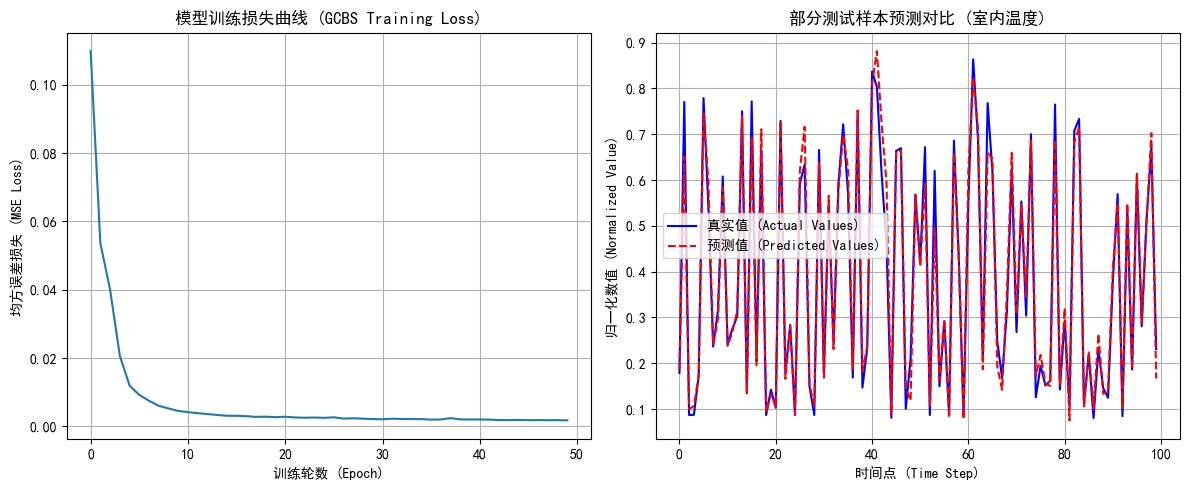

--- [第二部分] GCBS 模型处理完成 ---


In [ ]:
#   第二部分: 基于PyTorch的GCBS模型实现时间序列预测
#
#   本部分复现论文中的GCBS模型，用于预测温室内的关键环境指标。
#   流程: 数据归一化 -> 构建时间序列样本 -> 划分数据集 -> 模型训练 -> 性能评估
#
# =======================================================================================

print("\n--- [第二部分] 开始构建并训练 GCBS 预测模型 ---")

# === 1. 数据归一化 ===
# 使用 MinMaxScaler 将所有数据缩放到 [0, 1] 区间，这是神经网络训练的标准做法
print("--> 正在对数据进行归一化...")
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df_resampled)
normalized_df = pd.DataFrame(normalized_data, columns=df_resampled.columns, index=df_resampled.index)

# === 2. 构建时间序列样本 ===
# 定义一个函数，将时间序列数据转换为监督学习问题样本
# seq_length: 使用过去多少个时间点的数据作为输入特征
def create_sequences(data, seq_length=24): # 例如，使用过去12小时(24个30分钟点)的数据
    xs, ys = [], []
    data_array = data.values
    # 假设预测目标是: Indoor_Temp, Indoor_Hum, Indoor_CO2, Indoor_Soil_Temp (根据列的位置)
    # df_resampled.columns: ['Outdoor_Temp', 'Outdoor_Hum', 'Indoor_Temp', 'Indoor_Hum', 'Indoor_CO2', 'Indoor_Soil_Temp', 'Heating_Rate', 'Watering_Rate']
    # 目标列的索引: 0, 1，3，5
    #气温，湿度，co2，溶液温度
    target_indices = [0, 1, 3, 5] 
    
    for i in range(len(data_array) - seq_length):
        # x 是长度为 seq_length 的历史数据
        x = data_array[i:(i + seq_length)]
        # y 是紧接着的下一个时间点的4个目标值
        y = data_array[i + seq_length, target_indices]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LEN = 24 # 使用过去12小时 (24 * 30分钟) 的数据作为序列长度
X, y = create_sequences(normalized_df, SEQ_LEN)
print(f"--> 时间序列样本创建完成。输入样本维度: {X.shape}, 输出样本维度: {y.shape}")

# === 3. 划分数据集并创建DataLoader ===
# 将数据划分为训练集和测试集 (80% 训练, 20% 测试)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 将Numpy数组转换为PyTorch张量
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

# 使用TensorDataset和DataLoader来批量加载数据
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print("--> 数据集划分完成，DataLoader已创建。")

# === 4. 构建 GCBS 模型 (PyTorch版) ===
class GCBS_Model(nn.Module):
    def __init__(self, input_dim, hidden_dim=15, output_dim=4):
        super(GCBS_Model, self).__init__()
        # CNN层: 用于提取序列中的局部特征
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=3, padding=1)
        # BiGRU层: 用于捕捉长距离的时间依赖关系
        self.bigru = nn.GRU(input_size=64, hidden_size=hidden_dim, num_layers=2, batch_first=True, bidirectional=True)
        # Self-Attention层: 用于给序列中的不同时间点分配权重
        self.attention = nn.Linear(hidden_dim * 2, 1)
        # 全连接输出层
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        # 输入 x 的维度: (Batch, Seq_Len, Features)
        x = x.permute(0, 2, 1) # 调整维度以适应Conv1d: (Batch, Features, Seq_Len)
        
        # 通过CNN层
        x = torch.relu(self.conv1(x))
        
        # 调回维度以适应GRU: (Batch, Seq_Len, Features)
        x = x.permute(0, 2, 1)
        
        # 通过BiGRU层
        gru_out, _ = self.bigru(x) # gru_out 维度: (Batch, Seq_Len, Hidden*2)
        
        # 通过Attention层
        # 1. 计算注意力权重
        attention_weights = self.attention(gru_out) # (Batch, Seq_Len, 1)
        # 2. 使用softmax获取归一化的权重
        attention_weights = torch.softmax(attention_weights, dim=1)
        # 3. 加权求和
        attended_features = torch.sum(attention_weights * gru_out, dim=1) # (Batch, Hidden*2)
        
        # 通过全连接层得到最终输出
        output = self.fc(attended_features)
        return output

# === 5. 模型训练 ===
print("--> 开始 GCBS 模型训练...")
input_dim = X_train.shape[2]
model = GCBS_Model(input_dim=input_dim, hidden_dim=32, output_dim=4) # 增加hidden_dim以提升容量
criterion = nn.MSELoss() # 损失函数: 均方误差
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50 # 训练轮数
train_loss_history = []
for epoch in range(num_epochs):
    model.train() # 设置为训练模式
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    train_loss_history.append(avg_loss)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], 平均训练损失: {avg_loss:.6f}")

print("--> 模型训练完成。")

# === 6. 模型评估 ===
print("--> 开始在测试集上评估模型...")
model.eval() # 设置为评估模式
test_loss = 0
total_mae = 0
all_predictions = []
all_actuals = []

with torch.no_grad(): # 在评估阶段不计算梯度
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()
        
        # 计算MAE (Mean Absolute Error)
        mae = torch.mean(torch.abs(outputs - batch_y))
        total_mae += mae.item()
        
        all_predictions.append(outputs.numpy())
        all_actuals.append(batch_y.numpy())

avg_test_loss = test_loss / len(test_loader)
avg_mae = total_mae / len(test_loader)
print(f"--> 模型评估完成。平均测试损失: {avg_test_loss:.6f}, 平均绝对误差 (MAE): {avg_mae:.6f}")

# === 7. 结果可视化 ===
# 7.1 绘制训练损失曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history)
plt.title("模型训练损失曲线 (GCBS Training Loss)")
plt.xlabel("训练轮数 (Epoch)")
plt.ylabel("均方误差损失 (MSE Loss)")
plt.grid(True)

# 7.2 比较预测值与真实值
# 将所有批次的预测和真实值拼接起来
predictions = np.concatenate(all_predictions, axis=0)
actuals = np.concatenate(all_actuals, axis=0)

# 只选择第一个目标变量（室内温度）进行可视化比较
plt.subplot(1, 2, 2)
plt.plot(actuals[:100, 0], label='真实值 (Actual Values)', color='blue')
plt.plot(predictions[:100, 0], label='预测值 (Predicted Values)', color='red', linestyle='--')
plt.title("部分测试样本预测对比 (室内温度)")
plt.xlabel("时间点 (Time Step)")
plt.ylabel("归一化数值 (Normalized Value)")
plt.legend()
plt.grid(True)
plt.tight_layout() # 自动调整子图间距
plt.show()

print("--- [第二部分] GCBS 模型处理完成 ---")


--- [第三部分] 开始构建并求解 MDP 最优控制策略 ---
--> MDP状态空间定义完成，共 9 个状态。
--> 转移概率和奖励函数定义完成。
--> 开始使用值迭代算法求解最优策略...
--> MDP 在第 306 轮迭代后收敛。

--- MDP 最优控制策略表 ---
状态: Rational (理想状态)                -> 建议动作: 维持现状 (Wait)
状态: Overheating (过热)               -> 建议动作: 主动干预 (Act)
状态: Cold (过冷)                      -> 建议动作: 主动干预 (Act)
状态: Moisture Deficit (湿度不足)        -> 建议动作: 主动干预 (Act)
状态: Excess Moisture (湿度过高)         -> 建议动作: 主动干预 (Act)
状态: Excess CO2 (CO2超标)             -> 建议动作: 主动干预 (Act)
状态: Plant Stress (植物胁迫)            -> 建议动作: 主动干预 (Act)
状态: Yield Reduction (产量下降)         -> 建议动作: 主动干预 (Act)
状态: Emergency (紧急情况)               -> 建议动作: 主动干预 (Act)


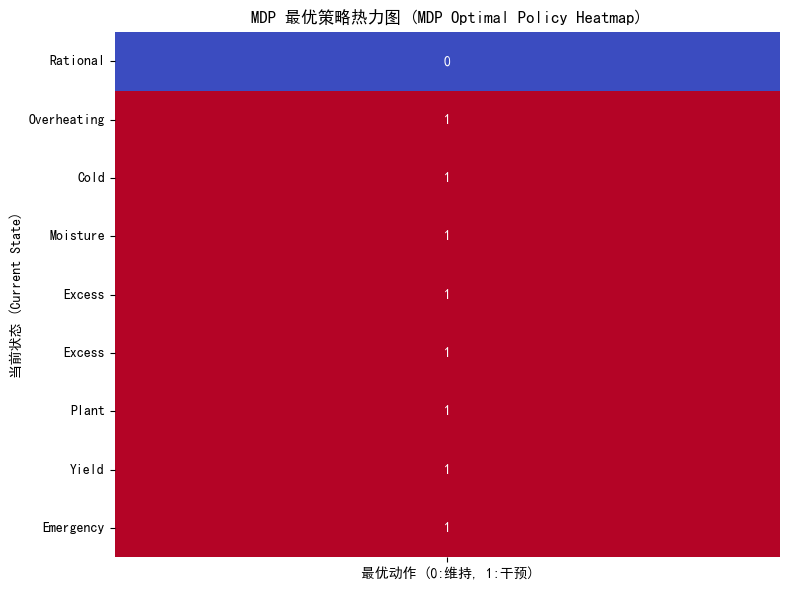

--- [第三部分] MDP 策略处理完成 ---


In [3]:
#   第三部分: 基于马尔可夫决策过程(MDP)的最优控制策略
#
#   本部分构建一个MDP模型来为温室环境控制制定最优策略。
#   流程: 定义状态空间 -> 定义动作空间 -> 定义转移概率和奖励 -> 使用值迭代算法求解 -> 输出最优策略
#
# =======================================================================================

print("\n--- [第三部分] 开始构建并求解 MDP 最优控制策略 ---")

# === 1. 定义状态空间 ===
# 根据论文，定义了9种可能的温室状态
states = [
    "Rational (理想状态)", "Overheating (过热)", "Cold (过冷)", 
    "Moisture Deficit (湿度不足)", "Excess Moisture (湿度过高)", 
    "Excess CO2 (CO2超标)", "Plant Stress (植物胁迫)", "Yield Reduction (产量下降)", "Emergency (紧急情况)"
]
n_states = len(states)
state_map = {name: i for i, name in enumerate(states)}
print(f"--> MDP状态空间定义完成，共 {n_states} 个状态。")

# === 2. 定义动作空间、转移概率 (Transition Probabilities) 和奖励 (Rewards) ===
# 定义动作
action_names = ["维持现状 (Wait)", "主动干预 (Act)"]
n_actions = len(action_names)

# --- 转移概率矩阵 P[a, s, s'] ---
# P[a, s, s'] 表示在状态 s 执行动作 a 后，转移到状态 s' 的概率
# P_wait 对应 Action 0: "Wait / Maintain" (不作为时的自然演变)，基于论文Table 2
P_wait = np.array([
    #  Rati, Over, Cold, Mois, Exce, Exce, Plan, Yiel, Emer
    [0.70, 0.08, 0.07, 0.06, 0.05, 0.02, 0.02, 0.00, 0.00], # From Rational
    [0.55, 0.20, 0.00, 0.05, 0.00, 0.00, 0.15, 0.00, 0.05], # From Overheating
    [0.55, 0.00, 0.20, 0.00, 0.10, 0.00, 0.10, 0.00, 0.05], # From Cold
    [0.60, 0.00, 0.00, 0.20, 0.00, 0.00, 0.15, 0.05, 0.00], # From Moisture Deficit
    [0.55, 0.00, 0.00, 0.00, 0.20, 0.00, 0.15, 0.07, 0.03], # From Excess Moisture
    [0.70, 0.00, 0.00, 0.00, 0.00, 0.15, 0.05, 0.00, 0.10], # From Excess CO2
    [0.40, 0.05, 0.00, 0.00, 0.00, 0.00, 0.25, 0.20, 0.10], # From Plant Stress
    [0.20, 0.00, 0.00, 0.00, 0.10, 0.00, 0.20, 0.40, 0.10], # From Yield Reduction
    [0.10, 0.00, 0.00, 0.00, 0.00, 0.00, 0.20, 0.00, 0.70]  # From Emergency
])

# P_act 对应 Action 1: "Active Control" (采取主动干预措施)
# 这是一个模拟的干预效果：假设干预后，有很大概率恢复到理想状态
P_act = np.zeros((n_states, n_states))
P_act[:, state_map["Rational (理想状态)"]] = 0.90 # 90%的概率恢复到理想状态
P_act[:, state_map["Plant Stress (植物胁迫)"]] = 0.10 # 10%的概率失败并导致植物胁迫

# 将两个动作的转移矩阵堆叠成一个三维数组
P = np.array([P_wait, P_act])

# --- 奖励函数 R(s, a) ---
# 定义奖励和成本。目标是最大化长期累积奖励
R_state = np.array([10, -2, -2, -2, -2, -2, -5, -20, -100]) # 处于不同状态的即时奖励
Cost_action = np.array([0, -3]) # 执行不同动作的成本（例如干预需要消耗能源）

# Reward R(s,a) = R_state(s) + Cost_action(a)
# 我们将在值迭代中直接计算
print("--> 转移概率和奖励函数定义完成。")

# === 3. 值迭代算法 (Value Iteration) ===
print("--> 开始使用值迭代算法求解最优策略...")
gamma = 0.95 # 折扣因子，表示未来奖励的重要性
V = np.zeros(n_states) # 初始化每个状态的价值函数 V(s)
policy = np.zeros(n_states, dtype=int) # 初始化策略 policy(s)
max_iterations = 1000
tolerance = 1e-6 # 收敛阈值

for i in range(max_iterations):
    V_prev = V.copy()
    
    # 初始化Q值表 Q(s, a)，存储在状态s下执行动作a的价值
    Q = np.zeros((n_actions, n_states))
    
    # 遍历所有动作计算Q值
    for a in range(n_actions):
        # Q(s, a) = R(s, a) + gamma * Σ P(s'|s, a) * V(s')
        # R(s, a) 是即时奖励，这里简化为 R_state(s) + Cost_action(a)
        # Σ P(s'|s, a) * V(s') 是期望的未来奖励
        immediate_reward = R_state + Cost_action[a]
        expected_future_reward = gamma * np.dot(P[a], V_prev)
        Q[a, :] = immediate_reward + expected_future_reward
    
    # 更新价值函数 V(s) = max_a Q(s, a)
    V = np.max(Q, axis=0)
    
    # 更新策略 policy(s) = argmax_a Q(s, a)
    policy = np.argmax(Q, axis=0)
    
    # 检查是否收敛
    if np.max(np.abs(V - V_prev)) < tolerance:
        print(f"--> MDP 在第 {i+1} 轮迭代后收敛。")
        break

# === 4. 输出并可视化最优策略 ===
print("\n--- MDP 最优控制策略表 ---")
results = []
for i, state_name in enumerate(states):
    action_name = action_names[policy[i]]
    results.append((state_name, action_name))
    print(f"状态: {state_name:<30} -> 建议动作: {action_name}")

# 使用热力图可视化策略
plt.figure(figsize=(8, 6))
sns.heatmap(policy.reshape(-1, 1), 
            annot=True, 
            cmap="coolwarm",
            yticklabels=[s.split(' ')[0] for s in states], # 使用截断的标签名
            xticklabels=["最优动作 (0:维持, 1:干预)"], 
            cbar=False)
plt.title("MDP 最优策略热力图 (MDP Optimal Policy Heatmap)")
plt.ylabel("当前状态 (Current State)")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("--- [第三部分] MDP 策略处理完成 ---")


In [4]:
#   第四部分: 智能温室闭环控制系统演示 (System Integration)
#
#   本部分将“预测模型”与“决策策略”结合，模拟真实的控制流程：
#   1. 获取当前环境数据 -> 2. GCBS预测未来状态 -> 3. 判定状态类别 -> 4. MDP查询最优动作
#
# =======================================================================================

print("\n--- [第四部分] 启动智能温室闭环控制演示 ---")
print(f"{'时间步':<10} | {'预测温度(°C)':<12} | {'预测湿度(%)':<12} | {'预测CO2':<10} | {'系统判定状态':<15} | {'执行最优决策':<15}")
print("-" * 90)

# 定义反归一化函数，用于将模型输出的 0-1 数值转回真实物理量以便展示
def inverse_transform_value(norm_val, col_index, scaler):
    # 构建一个与scaler输入维度一致的dummy数组
    dummy = np.zeros((1, len(scaler.min_)))
    dummy[0, col_index] = norm_val
    # 反归一化并取回对应列的值
    return scaler.inverse_transform(dummy)[0, col_index]

# 从测试集中随机抽取 10 个样本进行模拟
model.eval()
num_samples = 10
indices = np.random.choice(len(X_test), num_samples, replace=False)

# 这里的索引要与 target_indices = [0, 1, 3, 5] 对应
# 0 -> Temp(原列0), 1 -> Hum(原列1), 2 -> CO2(原列3), 3 -> SolTemp(原列5)
feat_idx_map = {0: 0, 1: 1, 2: 3} 

with torch.no_grad():
    for i, idx in enumerate(indices):
        # 1. 获取输入序列 (Batch=1)
        input_seq = X_test_tensor[idx].unsqueeze(0) 
        
        # 2. 模型预测
        pred_norm = model(input_seq).numpy()[0] # 输出维度 4
        
        # 3. 解析预测值 (反归一化)
        # 注意：这里的 pred_norm[0] 对应 target_indices[0] 即 Temperature
        pred_temp = inverse_transform_value(pred_norm[0], 0, scaler)
        pred_hum  = inverse_transform_value(pred_norm[1], 1, scaler)
        pred_co2  = inverse_transform_value(pred_norm[2], 3, scaler)
        
        # 4. 状态判定 (State Classification)
        # 这里使用简化的规则将连续变量映射到离散状态，模拟传感器阈值
        current_state_idx = 0 # 默认为 "Rational"
        
        if pred_temp > 30.0:
            current_state_idx = state_map["Overheating (过热)"]
        elif pred_temp < 10.0:
            current_state_idx = state_map["Cold (过冷)"]
        elif pred_hum < 40.0:
            current_state_idx = state_map["Moisture Deficit (湿度不足)"]
        elif pred_hum > 85.0:
            current_state_idx = state_map["Excess Moisture (湿度过高)"]
        elif pred_co2 > 1000.0: # 假设阈值
            current_state_idx = state_map["Excess CO2 (CO2超标)"]
            
        # 5. 决策执行 (Action Execution)
        # 查表：根据 MDP 算出的 policy 获取最优动作
        suggested_action_idx = policy[current_state_idx]
        suggested_action = action_names[suggested_action_idx]
        state_str = states[current_state_idx].split(' ')[0] # 获取状态简称
        
        # 打印日志
        print(f"T+{i:<8} | {pred_temp:<12.1f} | {pred_hum:<12.1f} | {pred_co2:<10.0f} | {state_str:<15} | {suggested_action:<15}")

print("-" * 90)
print("✅ 演示结束：系统成功根据 [GCBS预测结果] 自动执行了 [MDP最优决策]。")


--- [第四部分] 启动智能温室闭环控制演示 ---
时间步        | 预测温度(°C)     | 预测湿度(%)      | 预测CO2      | 系统判定状态          | 执行最优决策         
------------------------------------------------------------------------------------------
T+0        | 16.9         | 99.9         | 1612       | Excess          | 主动干预 (Act)     
T+1        | 37.6         | 47.6         | 1561       | Overheating     | 主动干预 (Act)     
T+2        | 17.7         | 88.9         | 1583       | Excess          | 主动干预 (Act)     
T+3        | 37.0         | 51.6         | 1065       | Overheating     | 主动干预 (Act)     
T+4        | 17.6         | 100.0        | 1604       | Excess          | 主动干预 (Act)     
T+5        | 15.6         | 99.1         | 1619       | Excess          | 主动干预 (Act)     
T+6        | 16.7         | 100.3        | 1635       | Excess          | 主动干预 (Act)     
T+7        | 16.1         | 98.4         | 1538       | Excess          | 主动干预 (Act)     
T+8        | 14.0         | 90.0         | 1604       | Excess        